In [29]:
from src.clean_data import get_cleaned_data

df = get_cleaned_data()
df

cleaning data...


,url,title,last_change,descriptions,price,broker,district,neubau,area,rooms,needs_fix
0,https://www.willhaben.at/iad/immobilien/d/eige...,"+ nähe augarten, top-sanierte 1 zimmer wohnun...",2024-04-02 08:10:00,zwischen augarten und donaukanal befindet sich...,139000.0,False,1200,None,32.34,1.0,False
1,https://www.willhaben.at/iad/immobilien/d/eige...,tolle studentenwohnung- wohnen im herzen favor...,2024-04-03 13:57:00,"tolle single-, studentenwohnung- wohnen im her...",129001.0,True,1100,True,32.11,1.0,None
2,https://www.willhaben.at/iad/immobilien/d/eige...,achtung! sanierungsbedürftige wohnung nur 149....,2024-03-27 12:40:00,willkommen in ihrer wohnung zur investition im...,149000.0,True,1100,False,48.42,2.0,True
3,https://www.willhaben.at/iad/immobilien/d/eige...,home 4 1 | single-schmuckstück | kernsaniert |...,2024-04-01 17:25:00,diese immobilie wird in form eines digitalen a...,115000.0,True,1150,False,25.00,1.0,False
4,https://www.willhaben.at/iad/immobilien/d/eige...,belagsfertige altbauwohnung mit viel potenzial!,2024-04-05 12:35:00,die belagsfertige wohnung befindet sich in 3.l...,140000.0,True,1170,False,51.00,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...
431,https://www.willhaben.at/iad/immobilien/d/eige...,klein / kompakt / günstig! altbauwohnung mit r...,2024-04-01 00:40:00,klein / kompakt / günstig! altbauwohnung mit r...,115000.0,True,1100,False,32.57,1.0,True
434,https://www.willhaben.at/iad/immobilien/d/eige...,1-zimmer-altbauwohnung zum selbst gestalten!,2024-04-05 08:30:00,top 29 im 2. stockhierbei handelt es sich um e...,99000.0,True,1140,False,28.41,1.0,True
435,https://www.willhaben.at/iad/immobilien/d/eige...,generalsaniertes haus in beliebter lage i u-ba...,2024-04-01 18:10:00,das richtige zusammenspiel von klassik und mod...,99000.0,True,1170,None,NaN,1.0,None
436,https://www.willhaben.at/iad/immobilien/d/eige...,# sq - unbefristete wohnung - nähe millenium c...,2024-04-02 05:06:00,zum verkauf gelangt eine unbefristet vermietet...,125000.0,True,1200,False,45.50,NaN,False


# choose best

remove:

- sanierungsbedürftig
- untervermietet

good:

- sonnig
- südseitig


In [33]:
import webbrowser

for i in range(len(df)):
    row = df.iloc[i]
    url = row["url"]

    needs_fix = row["needs_fix"]
    if (needs_fix is not None) and (needs_fix == False):
        print("Skipping", url)
        continue

    # print(needs_fix)


Skipping https://www.willhaben.at/iad/immobilien/d/eigentumswohnung/wien/wien-1200-brigittenau/-naehe-augarten-top-sanierte-1-zimmer-wohnung-u6-und-u4-ca-500-meter-entfernt-945993115/
Skipping https://www.willhaben.at/iad/immobilien/d/eigentumswohnung/wien/wien-1150-rudolfsheim-fuenfhaus/home-4-1-single-schmuckstueck-kernsaniert-ubahn-naehe-660215211/
Skipping https://www.willhaben.at/iad/immobilien/d/eigentumswohnung/wien/wien-1200-brigittenau/-schnaeppchen-in-absoluter-trendlage-nahe-u6-jaegerstrasse-1465397881/
Skipping https://www.willhaben.at/iad/immobilien/d/eigentumswohnung/wien/wien-1030-landstrasse/klein-aber-fein-renovierte-garconniere-in-ruhelage-im-3-bezirk-1222409903/
Skipping https://www.willhaben.at/iad/immobilien/d/eigentumswohnung/wien/wien-1160-ottakring/entzueckende-singlewohnung-1942082167/
Skipping https://www.willhaben.at/iad/immobilien/d/eigentumswohnung/wien/wien-1220-donaustadt/klein-aber-fein-moderne-1-zimmer-wohnung-in-begehrter-lage-wiens-1934574630/
Skippin

# explore data

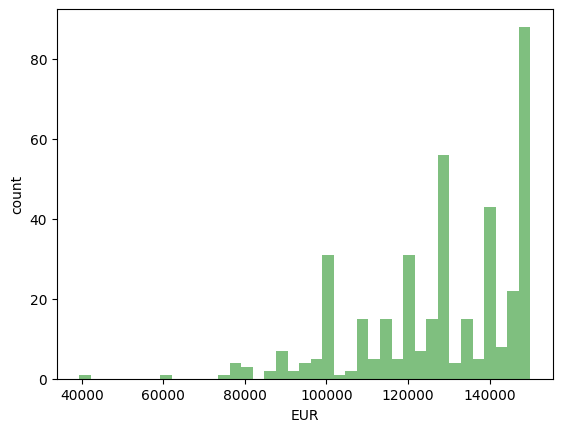

In [ ]:
# price distribution

import matplotlib.pyplot as plt

num_bins = len(df) // 10
plt.hist(df["price"], bins=num_bins, color="green", alpha=0.5) 
plt.xlabel("EUR")
plt.ylabel("count")
plt.show()

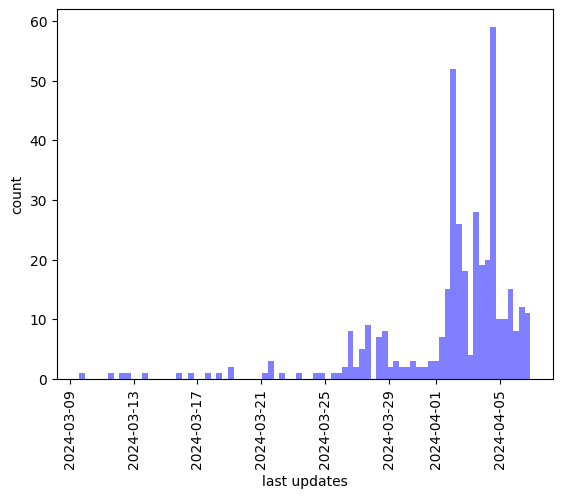

In [ ]:
# update distribution

num_bins = len(df) // 5
plt.hist(df["last_change"], bins=num_bins, color="blue", alpha=0.5)

plt.xticks(rotation=90)
plt.ylabel("count")
plt.xlabel("last updates")
plt.show()